# Kay (2012) Figure 7, Panel 1

## CERES-EBAF SW and LW cloud forcings (2006-2010)

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fonty thing messes up normal plotting through xarray, commented out

In [13]:
# Fix fonts
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.size'] = 10
# mpl.rcParams['text.usetex'] = True

#### Interpolation functions with xESMF

In [2]:
from interp_functions import *

#### Taylor plot specific imports

In [3]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

#### Stats specific imports

In [4]:
import scipy.stats as stats

#### Masking imports

In [5]:
import numpy.ma as ma

### Get observations on their native grid

In [8]:
ceres_obs_dir = '/glade/u/home/jonahshaw/obs/CERES_EBAF/'
ceres_obs_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202002.nc'

In [9]:
ceres_obs_native = xr.open_dataset("%s/%s" % (ceres_obs_dir,ceres_obs_file))

In [10]:
ceres_obs_lwcf = ceres_obs_native['toa_lw_clr_c_mon'] - ceres_obs_native['toa_lw_all_mon']
ceres_obs_swcf = ceres_obs_native['toa_sw_clr_c_mon'] - ceres_obs_native['toa_sw_all_mon']

### Create mask here (before processing)

Grab the valid minima and maxima to create mask

In [11]:
def get_min_max(da):
    '''
    Requires the file to have identifiable limits/null values.
    '''
    
    _min = da.valid_min
    _min_flt = np.float(_min.split(' ')[-1])
    
    _max = da.valid_max
    _max_flt = np.float(_max.split(' ')[-1])
    
    return _min_flt,_max_flt

In [12]:
def get_mask(da):
    '''
    Return values to mask (i.e. to use with where() after inverting).
    Requires the file to have identifiable limits/null values.
    '''
    
    _min,_max = get_min_max(da)

    # these values are True if they should be discarded, should also catch nans
    mask = np.invert(np.bitwise_and(da < _max, da > _min,))
    
    return mask

### Create mask for CERES LWCF

In [13]:
mask1 = get_mask(ceres_obs_native['toa_lw_clr_c_mon'])

mask2 = get_mask(ceres_obs_native['toa_lw_all_mon'])

# bitwise_or here because if either obs is bad mask it
lwcf_mask = np.bitwise_or(mask1,mask2)

### Create mask for CERES SWCF

In [14]:
mask1 = get_mask(ceres_obs_native['toa_sw_clr_c_mon'])

mask2 = get_mask(ceres_obs_native['toa_sw_all_mon'])

# bitwise_or here because if either obs is bad mask it
swcf_mask = np.bitwise_or(mask1,mask2)

In [59]:
ceres_obs_lwcf_ma = ma.masked_array(ceres_obs_lwcf, mask=lwcf_mask)

MaskError: Mask and data not compatible: data size is 64800, mask size is 15552000.

#### Time average before Taylor diagram calculations.

I am only masking here because the values that come out of this should not need masking

In [15]:
ceres_obs_lwcf = ceres_obs_lwcf.where(np.invert(lwcf_mask)).sel(time=slice('2006-01-01','2010-12-31')).mean('time')
ceres_obs_swcf = ceres_obs_swcf.where(np.invert(swcf_mask)).sel(time=slice('2006-01-01','2010-12-31')).mean('time')

__Grid is 1x1 deg__

In [16]:
ceres_obs_lwcf.lat,ceres_obs_lwcf.lon;

### Grab post-processed CAM4 and CAM5 data

In [17]:
post_proc_path = '/glade/u/home/jonahshaw/s/archive/Kay_COSP_2012/'

In [18]:
cam4_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam4_1deg_release_amip')
cam5_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam5_1deg_release_amip')

In [19]:
cam4_sw_file = [i for i in os.listdir(cam4_proc_dir) if "SWCF" in i]
cam4_lw_file = [i for i in os.listdir(cam4_proc_dir) if "LWCF" in i]

cam5_sw_file = [i for i in os.listdir(cam5_proc_dir) if "SWCF" in i]
cam5_lw_file = [i for i in os.listdir(cam5_proc_dir) if "LWCF" in i]

Open post-processed cloud forcing files from CAM4 and CAM5

In [20]:
cam4_swcf = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_sw_file[0]))#['SWCF']
cam4_lwcf = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_lw_file[0]))#['LWCF']

cam5_swcf = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_sw_file[0]))#['SWCF']
cam5_lwcf = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_lw_file[0]))#['LWCF']

Correct CAM-specific time bound labelling.

In [21]:
cam4_swcf['time'] = cam4_swcf['time_bnds'].isel(nbnd=0)
cam4_lwcf['time'] = cam4_lwcf['time_bnds'].isel(nbnd=0)

cam5_swcf['time'] = cam5_swcf['time_bnds'].isel(nbnd=0)
cam5_lwcf['time'] = cam5_lwcf['time_bnds'].isel(nbnd=0)

Time select and time average CAM files (2001-2010)

In [22]:
cam4_swcf = cam4_swcf['SWCF'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam4_lwcf = cam4_lwcf['LWCF'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

cam5_swcf = cam5_swcf['SWCF'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_lwcf = cam5_lwcf['LWCF'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

### Interpolate CAM output to the native observations grid (1x1 deg)

In [25]:
cam4_swcf_interp,rgrdr = interp_like2D(cam4_swcf,ceres_obs_swcf)

cam4_lwcf_interp,_ = interp_like2D(cam4_lwcf,regridder=rgrdr)
cam5_swcf_interp,_ = interp_like2D(cam5_swcf,regridder=rgrdr)
cam5_lwcf_interp,_ = interp_like2D(cam5_lwcf,regridder=rgrdr)

#### Check the interpolation worked

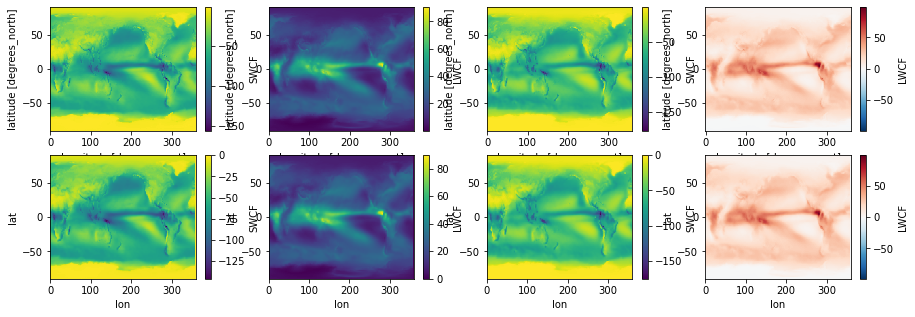

In [26]:
fig,axs = plt.subplots(2,4,figsize=(15,5))

cam4_swcf.plot(ax=axs[0,0])
cam4_swcf_interp['SWCF'].plot(ax=axs[1,0])

cam4_lwcf.plot(ax=axs[0,1])
cam4_lwcf_interp['LWCF'].plot(ax=axs[1,1])

cam5_swcf.plot(ax=axs[0,2])
cam5_swcf_interp['SWCF'].plot(ax=axs[1,2])

cam5_lwcf.plot(ax=axs[0,3])
cam5_lwcf_interp['LWCF'].plot(ax=axs[1,3])

### Define function for calculating relevant values

In [27]:
def calculate(cntl,test):
    """Calculate Taylor statistics for making taylor diagrams."""
    
    _cntl = add_weights(cntl)
    wgt = np.array(_cntl['cell_weight'])
    
    # calculate sums and means
    sumwgt = np.sum(wgt)
    meantest = np.sum(wgt*test)/sumwgt
    meancntl = np.sum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.sum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

### Calculate Taylor-relevant values

#### Set-up

In [28]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'SWCF': ceres_obs_swcf,
        'LWCF': ceres_obs_lwcf,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'SWCF':[cam4_swcf_interp,cam5_swcf_interp],'LWCF':[cam4_lwcf_interp,cam5_lwcf_interp]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [29]:
varnames = ['SWCF','LWCF']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

In [30]:
# Fix fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

### Plot

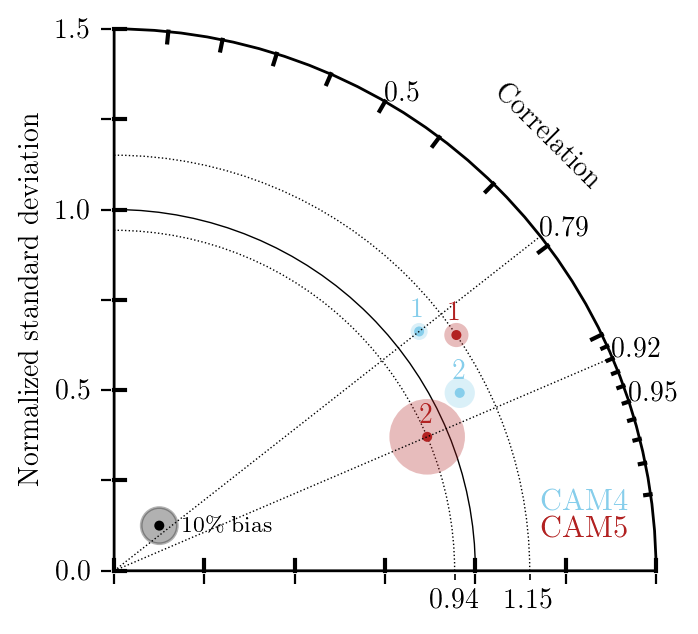

In [31]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Repeat with the original observations (from the 2012 paper directly)

### Load original data as a cross-check

In [32]:
og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'
# os.listdir(og_dir)

In [33]:
og_swcf = xr.open_dataset('%s/CERES-EBAF.SWCF.nc' % (og_dir))
og_lwcf = xr.open_dataset('%s/CERES-EBAF.LWCF.nc' % (og_dir))

In [35]:
og_swcf = og_swcf.rename({'SWCFTOA':'SWCF'})
og_lwcf = og_lwcf.rename({'LWCFTOA':'LWCF'})

#### Set-up

In [36]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'SWCF': og_swcf,
        'LWCF': og_lwcf,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'SWCF':[cam4_swcf_interp,cam5_swcf_interp],'LWCF':[cam4_lwcf_interp,cam5_lwcf_interp]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [39]:
_bias

<xarray.Dataset>
Dimensions:      ()
Data variables:
    SWCF         float64 -0.02192
    cell_weight  float64 -7.019e+03

In [42]:
varnames = ['SWCF','LWCF']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr[var]
        ratio[ivar,itest] = _ratio[var]
        bias[ivar,itest] = _bias[var]
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

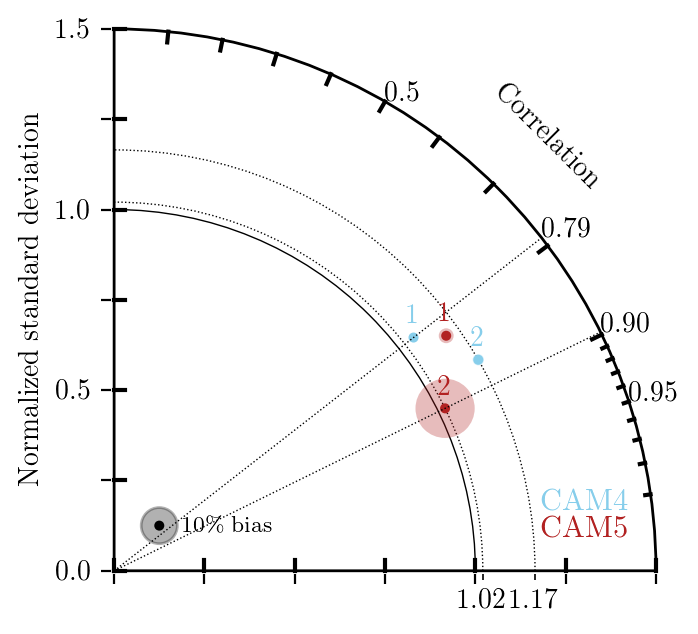

In [43]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

### Yay!!!